In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import bayesflow as bf
import numpy as np
from src.AmortizedMixture import *
from src.models.NormalHmm import *
from model import model


import matplotlib.pyplot as plt

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
summary_net = bf.networks.SequenceNetwork(summary_dim=model.n_par*3, num_conv_layers=4, bidirectional=True)
amortized_posterior=bf.amortizers.AmortizedPosterior(
            inference_net=bf.networks.InvertibleNetwork(num_params=model.n_par, num_coupling_layers=10, coupling_design="spline"), 
            summary_net=summary_net,
            summary_loss_fun="MMD"
        )

In [3]:
trainer = bf.trainers.Trainer(amortizer=amortized_posterior, generative_model=model, checkpoint_path="checkpoints/posterior", configurator=lambda x: x)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [4]:
%time
h = trainer.train_online(epochs=100, iterations_per_epoch=1000, batch_size=32)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


Training epoch 1:  88%|████████▊ | 878/1000 [03:37<00:30,  4.04it/s, Epoch: 1, Iter: 878,Loss: 5.508,W.Decay: 0.138,Avg.Loss: 7.593,Avg.W.Decay: 0.198,LR: 5.00E-04]  


KeyboardInterrupt: 

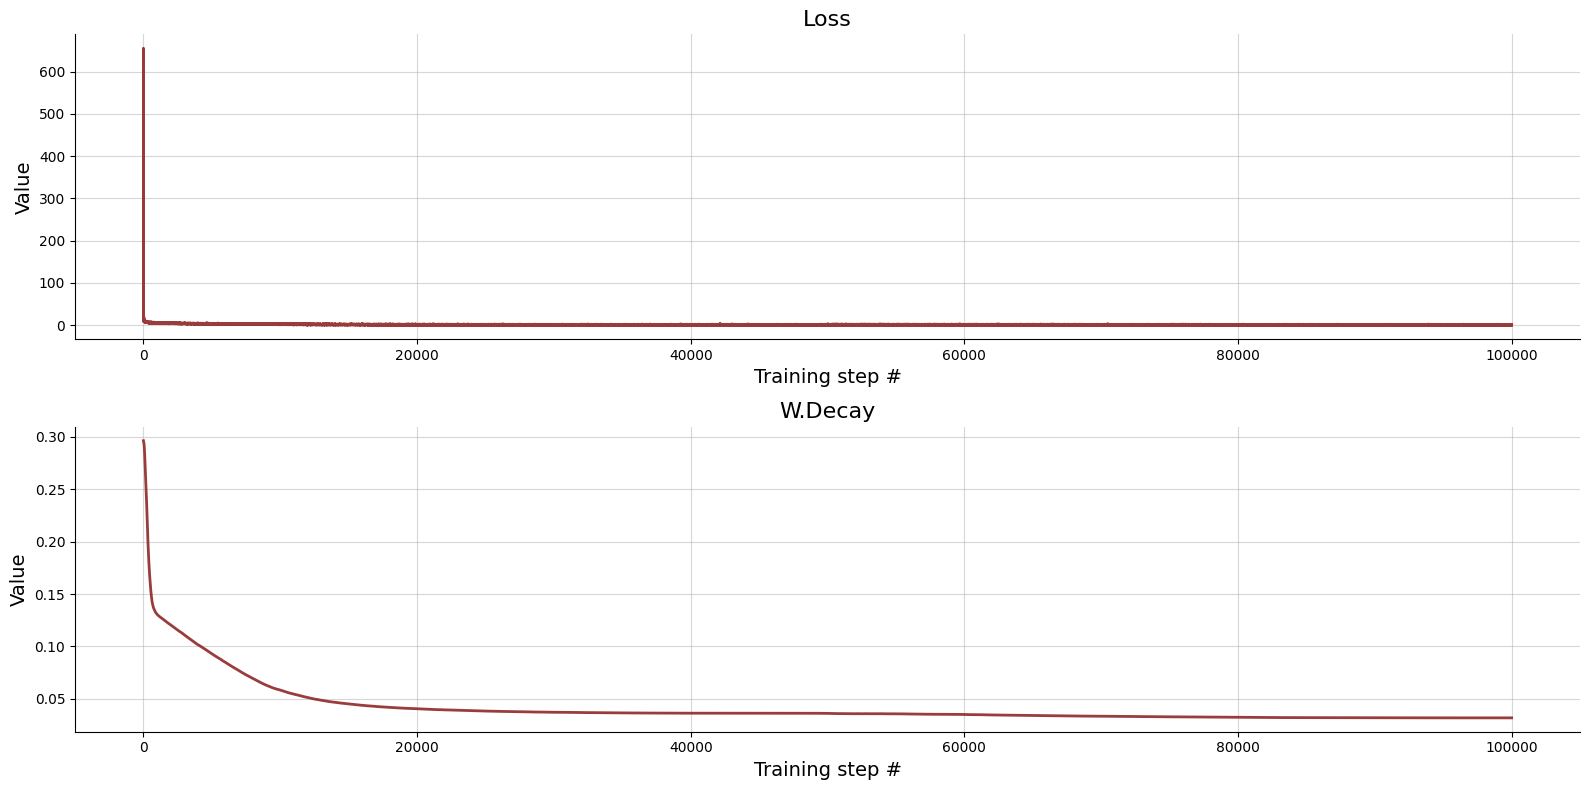

In [ ]:
f=bf.diagnostics.plot_losses(h)

In [ ]:
df = model(1000, context = {'n_obs': 100})

In [ ]:
z, _ = trainer.amortizer(df)

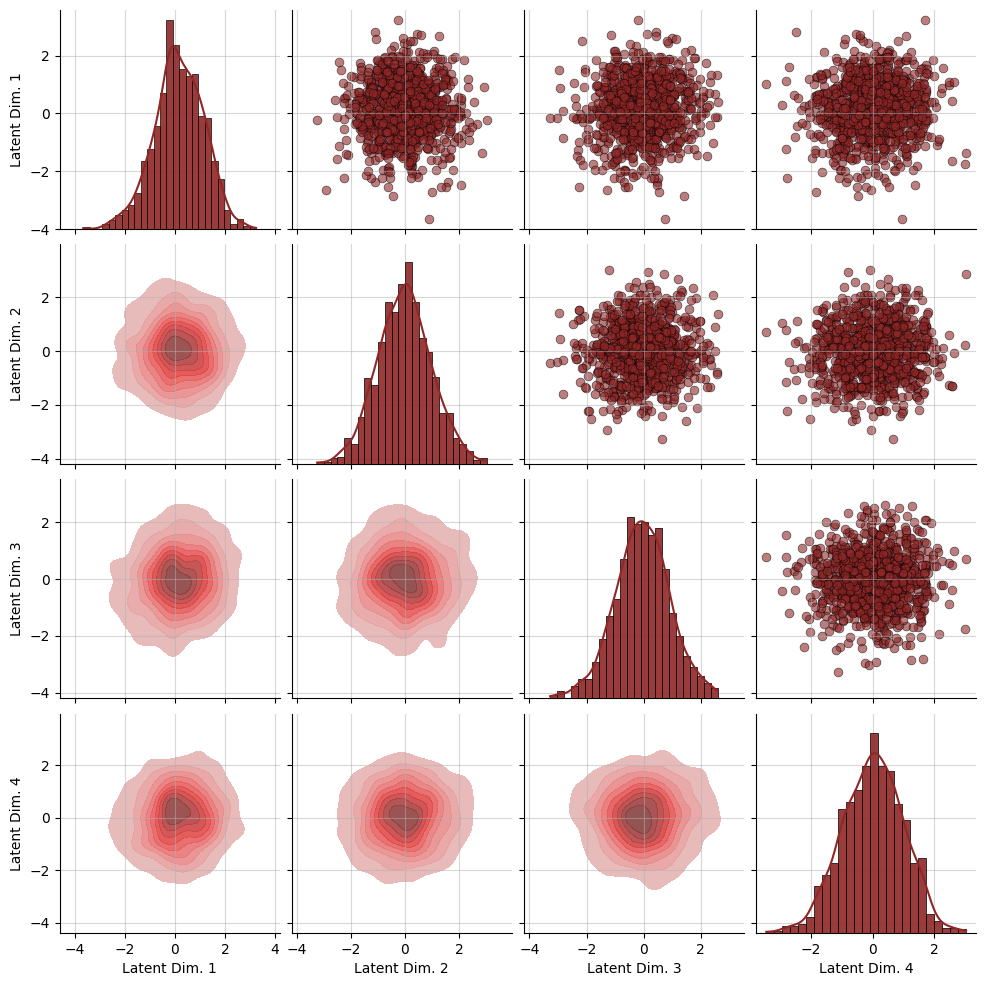

In [ ]:
f = bf.diagnostics.plot_latent_space_2d(z)

In [ ]:
prior_samples = df['parameters']
posterior_samples = trainer.amortizer.sample(df, n_samples=1000)

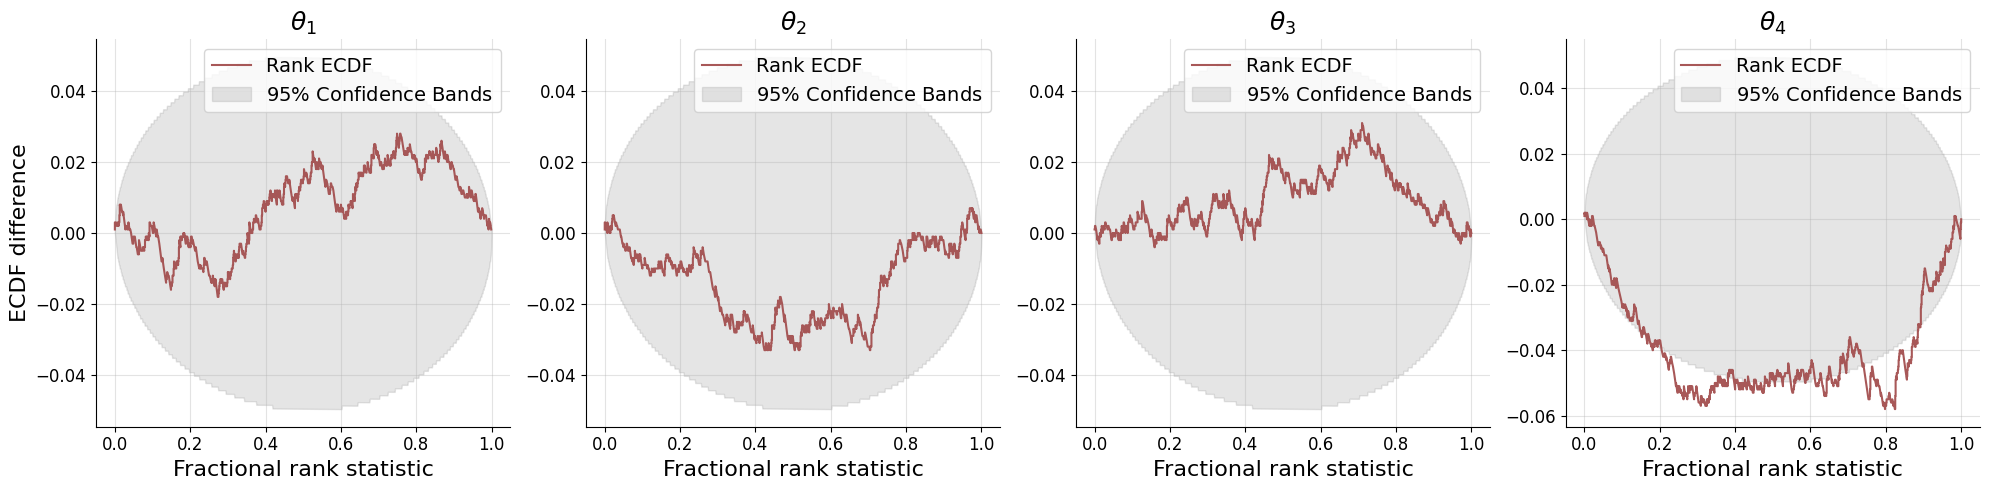

In [ ]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples, difference=True)

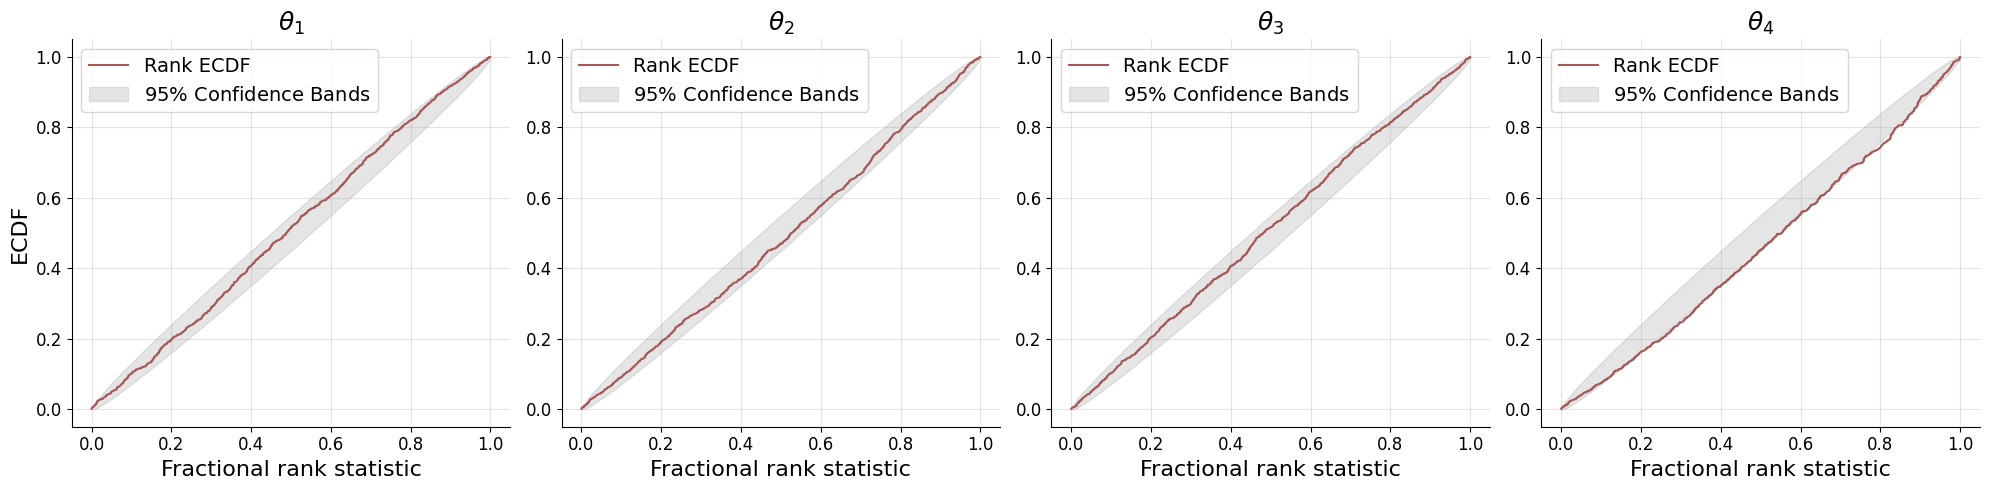

In [ ]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples)

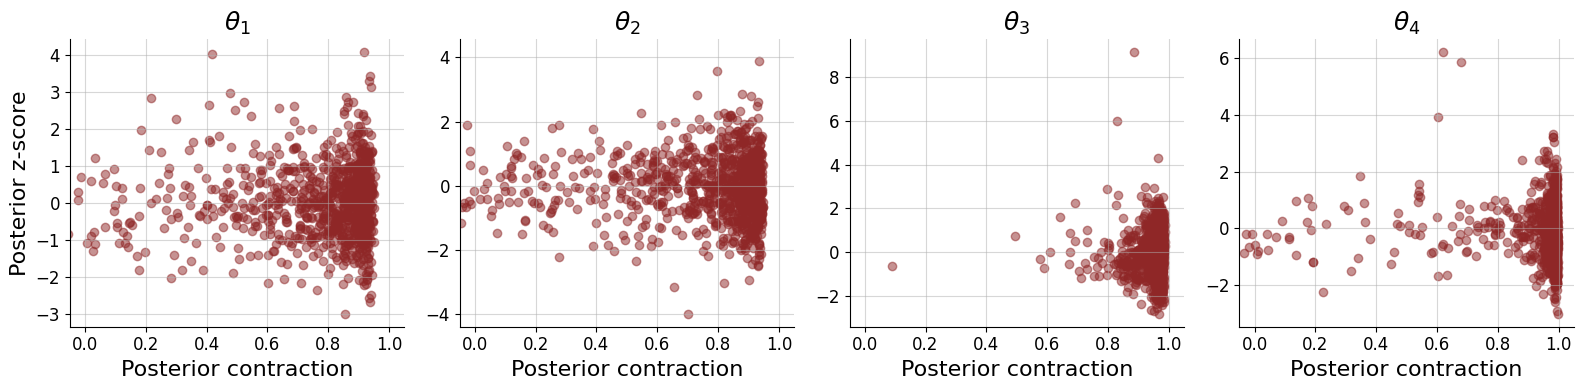

In [ ]:
f = bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_samples)

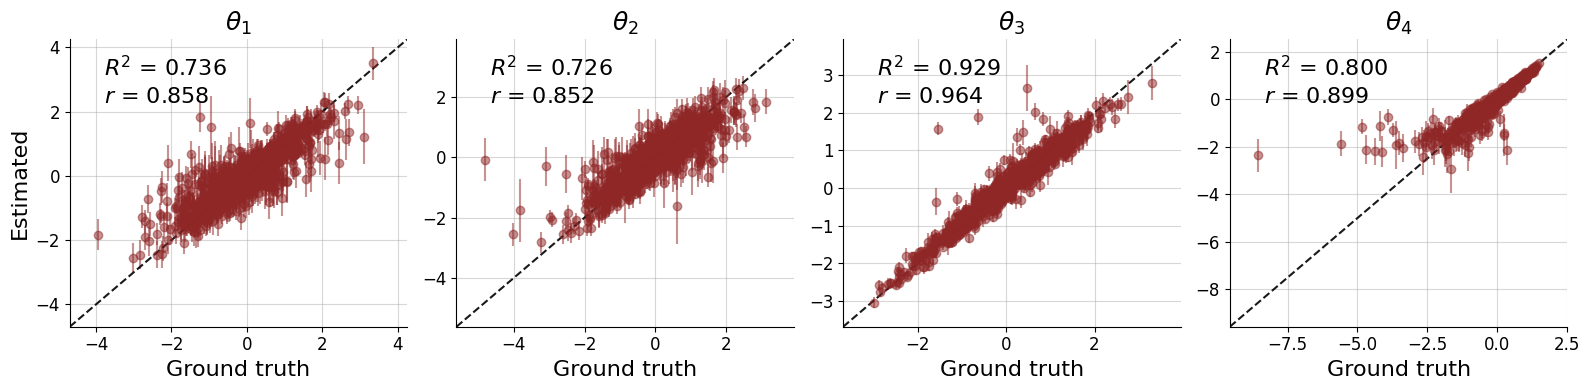

In [ ]:
f = bf.diagnostics.plot_recovery(posterior_samples, prior_samples)